In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

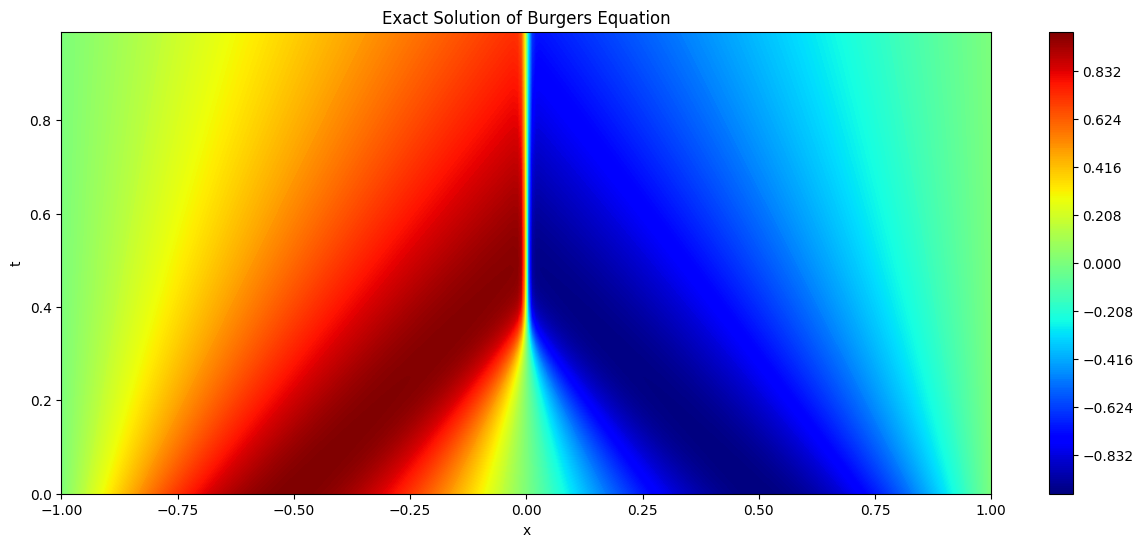

In [ ]:
#data loding(downloaded from deepxde documentation)
data=np.load('Burgers.npz')
t_ref,x_ref,exact=data['t'],data['x'],data['usol'].T
x_ref,t_ref=np.meshgrid(x_ref,t_ref)

#Plot the exact solution
plt.figure(figsize=(15, 6))
plt.contourf(x_ref, t_ref, exact, levels=250, cmap='jet')
plt.colorbar()
plt.title('Exact Solution of Burgers Equation')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [17]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden=nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self,x,t):
        inputs = torch.cat((x, t), dim=1)
        u=self.hidden(inputs)
        return u

In [18]:
def pde_residual(model, x, t,nu=0.01):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    # Compute gradients
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # Burgers' equation residual
    residual = u_t + u * u_x - nu/(np.pi) * u_xx
    return residual

def initial_condition(x):
    return -torch.sin(np.pi * x)

def boundary_condition(x,t):
    return torch.zeros_like(t)

In [19]:
x=torch.linspace(-1,1,200).view(-1,1)
t=torch.linspace(-1,1,200).view(-1,1)
x_train,t_train = torch.meshgrid(x.squeeze(), t.squeeze(),indexing='xy')
x_train = x_train.reshape(-1, 1)
t_train = t_train.reshape(-1, 1)

In [22]:
model=PINN()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [23]:
num_epochs = 12000
for epoch in range(num_epochs):
    model.train()
    
    #initial condition loss
    u_pred=model(x,torch.zeros_like(x))  #u(x,0)
    u_true=initial_condition(x)
    loss_ic = torch.mean((u_pred - u_true) ** 2)

    #boundary condition loss
    u_pred_left = model(torch.full_like(t,-1), t)  #u(-1,t)
    u_pred_right = model(torch.full_like(t,1), t)  #u(1,t)
    loss_bc = torch.mean((u_pred_left - boundary_condition(torch.full_like(t, -1), t)) ** 2) + \
               torch.mean((u_pred_right - boundary_condition(torch.full_like(t, 1), t)) ** 2)
    
    #pde residual loss
    residual = pde_residual(model, x_train, t_train)
    loss_pde = torch.mean(residual ** 2)

    #total loss
    loss = loss_ic + loss_bc + loss_pde

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, IC Loss: {loss_ic.item():.4f}, BC Loss: {loss_bc.item():.4f}, PDE Loss: {loss_pde.item():.4f}')

Epoch 0, Loss: 0.5252, IC Loss: 0.5025, BC Loss: 0.0226, PDE Loss: 0.0002
Epoch 1000, Loss: 0.1219, IC Loss: 0.0695, BC Loss: 0.0038, PDE Loss: 0.0486
Epoch 2000, Loss: 0.1102, IC Loss: 0.0609, BC Loss: 0.0030, PDE Loss: 0.0464
Epoch 3000, Loss: 0.0953, IC Loss: 0.0526, BC Loss: 0.0023, PDE Loss: 0.0405
Epoch 4000, Loss: 0.0785, IC Loss: 0.0392, BC Loss: 0.0025, PDE Loss: 0.0369
Epoch 5000, Loss: 0.0722, IC Loss: 0.0353, BC Loss: 0.0024, PDE Loss: 0.0346
Epoch 6000, Loss: 0.0707, IC Loss: 0.0343, BC Loss: 0.0022, PDE Loss: 0.0343
Epoch 7000, Loss: 0.0699, IC Loss: 0.0340, BC Loss: 0.0020, PDE Loss: 0.0339
Epoch 8000, Loss: 0.0697, IC Loss: 0.0348, BC Loss: 0.0017, PDE Loss: 0.0332
Epoch 9000, Loss: 0.0687, IC Loss: 0.0337, BC Loss: 0.0018, PDE Loss: 0.0332
Epoch 10000, Loss: 0.0695, IC Loss: 0.0331, BC Loss: 0.0019, PDE Loss: 0.0345
Epoch 11000, Loss: 0.0679, IC Loss: 0.0340, BC Loss: 0.0015, PDE Loss: 0.0324


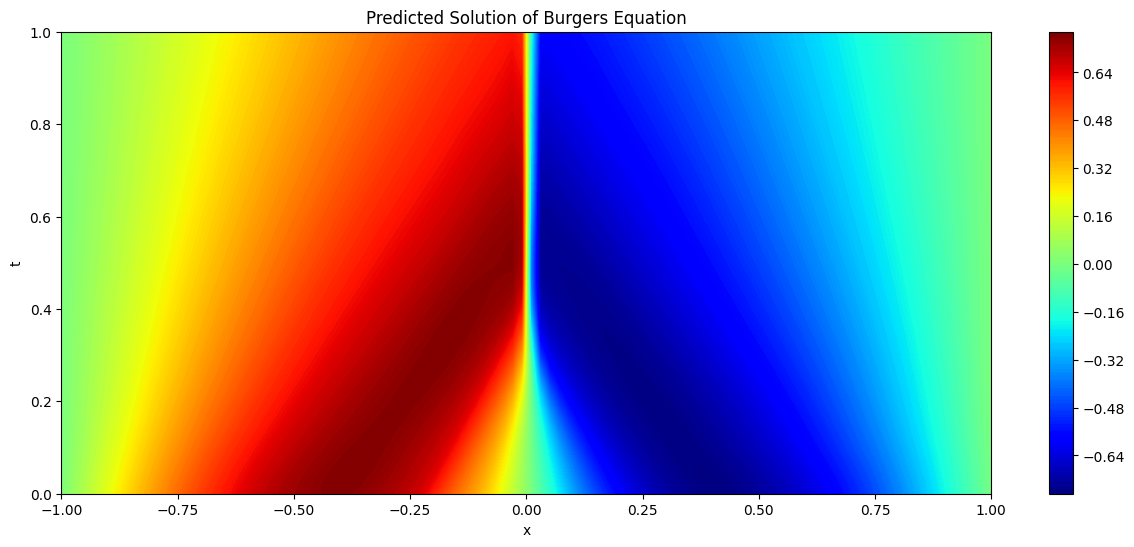

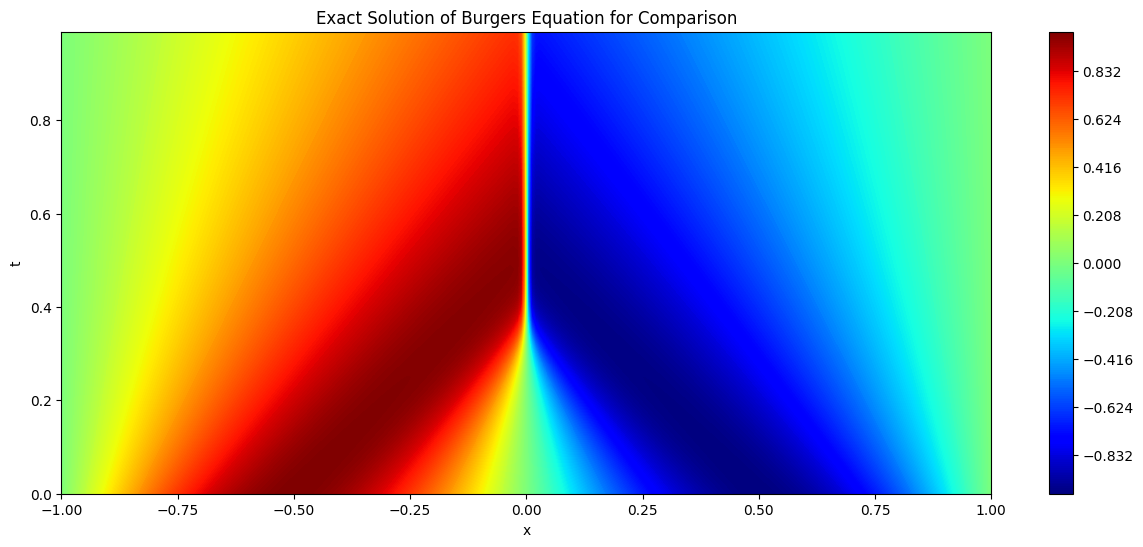

In [31]:
x_test = torch.linspace(-1, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
x_test, t_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='xy')
x_test = x_test.reshape(-1, 1)  
t_test = t_test.reshape(-1, 1)

model.eval()
with torch.no_grad():
    u_pred = model(x_test, t_test).numpy().reshape(100, 100)
    x_test = x_test.numpy().reshape(100, 100)
    t_test = t_test.numpy().reshape(100, 100)

# Plot the predicted solution
plt.figure(figsize=(15, 6)) 
plt.contourf(x_test, t_test, u_pred, levels=250, cmap='jet')
plt.colorbar()  
plt.title('Predicted Solution of Burgers Equation')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

# exact solution for comparison
exact_solution = exact[:100, :100]
# Plot the exact solution for comparison
plt.figure(figsize=(15, 6))
plt.contourf(x_ref, t_ref, exact, levels=250, cmap='jet')
plt.colorbar()
plt.title('Exact Solution of Burgers Equation for Comparison')
plt.xlabel('x')
plt.ylabel('t')
plt.show()
